# Sistemas de recomendación

In [ ]:
#!pip install scikit-surprise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
user = pd.read_csv('demo_11_dataset/BX-Users.csv', sep=';', encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('demo_11_dataset/BX-Book-Ratings.csv', sep=';', encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df.head()

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Veamos la distribución de las valoraciones

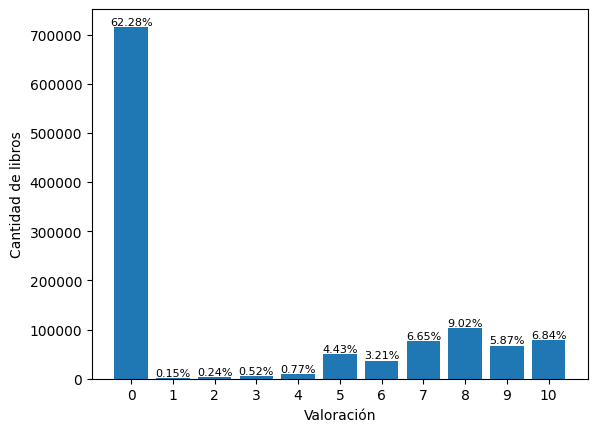

In [4]:
data = df['bookRating'].value_counts().sort_index(ascending=False)

p1 = plt.bar(data.index,data.values)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( f"{height/data.values.sum()*100:.2f}%",(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)

plt.xticks(np.arange(0,11,1))
plt.ylabel('Cantidad de libros')
plt.xlabel('Valoración')
plt.show()

Veamos cómo es la distribución de número de valoraciones por libro

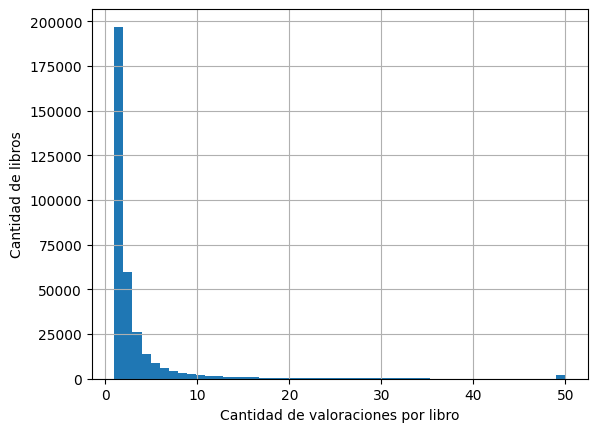

In [5]:
data = df.groupby('ISBN')['bookRating'].count()

data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por libro')
plt.ylabel('Cantidad de libros')
plt.show()

In [6]:
# Los 10 libros más votados
data.sort_values(ascending=False)[:10]

ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
044023722X     647
0679781587     639
0142001740     615
067976402X     614
0671027360     586
Name: bookRating, dtype: int64

Ahora podemos pensar en la distribución de cantidad de valoraciones por usuario

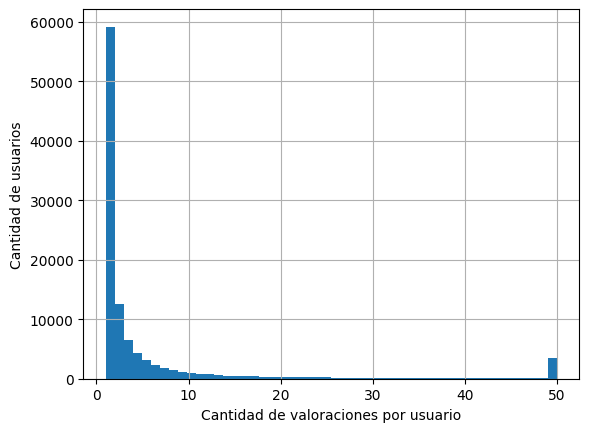

In [7]:
data = df.groupby('userID')['bookRating'].count()
data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por usuario')
plt.ylabel('Cantidad de usuarios')
plt.show()

La mayoria de los usuarios dan menos de 10 valoraciones. Cuántas valoraciones dio el usuario más activo?

In [8]:
df

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0
...,...,...,...
1149775,278854,0425163393,7
1149776,278854,0515087122,0
1149777,278854,0553275739,6
1149778,278854,0553578596,0


In [9]:
df.groupby('userID')['bookRating'].count().sort_values(ascending=False)[:5]

userID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
Name: bookRating, dtype: int64

Tanto el número de valoraciones por libro y el número de valoraciones por usuario tienen distribuciones que decaen exponencialmente!

Para evitar problemas de memoria, vamos a filtrar los libros y los usuarios "outlayers". 

In [10]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


Armamos un array booleano que nos indica cuáles ISBN's cumplen con la condición lógica de al menos tener 50 ratings

In [11]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books

ISBN
0971880107     True
0316666343     True
0385504209     True
0060928336     True
0312195516     True
              ...  
0916211223    False
0916211231    False
0916211274    False
0916211282    False
1569661057    False
Name: count, Length: 340556, dtype: bool

Luego, nos quedamos sólo con los que los cumplen

In [12]:
filter_books = filter_books[filter_books].index.tolist()
filter_books

['0971880107',
 '0316666343',
 '0385504209',
 '0060928336',
 '0312195516',
 '044023722X',
 '0679781587',
 '0142001740',
 '067976402X',
 '0671027360',
 '0446672211',
 '059035342X',
 '0316601950',
 '0375727345',
 '044021145X',
 '0452282152',
 '0440214041',
 '0804106304',
 '0440211727',
 '0345337662',
 '0060930535',
 '0440226430',
 '0312278586',
 '0743418174',
 '0671021001',
 '0345370775',
 '0446605239',
 '0156027321',
 '0440241073',
 '0671003755',
 '0060976845',
 '1400034779',
 '0786868716',
 '0440234743',
 '0440222656',
 '0440221471',
 '0345361792',
 '0440236673',
 '0345417623',
 '0316769487',
 '0446610038',
 '0385484518',
 '0446310786',
 '044022165X',
 '0375706771',
 '0440225701',
 '0440220602',
 '0060502258',
 '0446606812',
 '0345353145',
 '044651652X',
 '0140293248',
 '0345443284',
 '0440206154',
 '0440213525',
 '006101351X',
 '0316284955',
 '0312291639',
 '0375707972',
 '0439064872',
 '0060934417',
 '0385335482',
 '0671510053',
 '0440224764',
 '0452282829',
 '0385492081',
 '06848447

In [13]:
condicion1 = (df['ISBN'].isin(filter_books))
df[condicion1]['ISBN'].value_counts()

ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
              ... 
0812513711      51
0671020293      51
0670896764      51
0394281802      51
0446613053      51
Name: count, Length: 2125, dtype: int64

Hacemos lo mismo con los usuarios

In [14]:
min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()
condicion2 = (df['userID'].isin(filter_users))
df_new = df[(condicion2 & condicion1)]

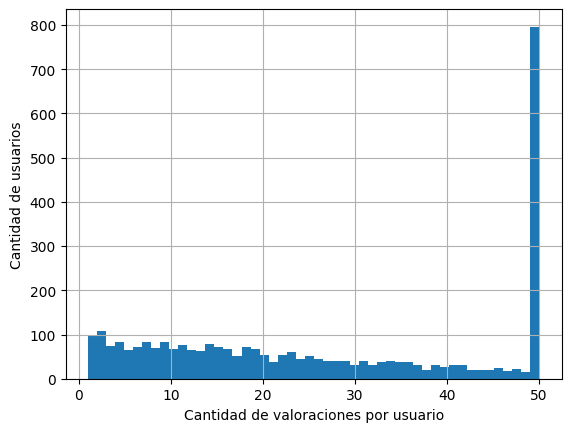

In [15]:
data = df_new.groupby('userID')['bookRating'].count()
data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por usuario')
plt.ylabel('Cantidad de usuarios')
plt.show()

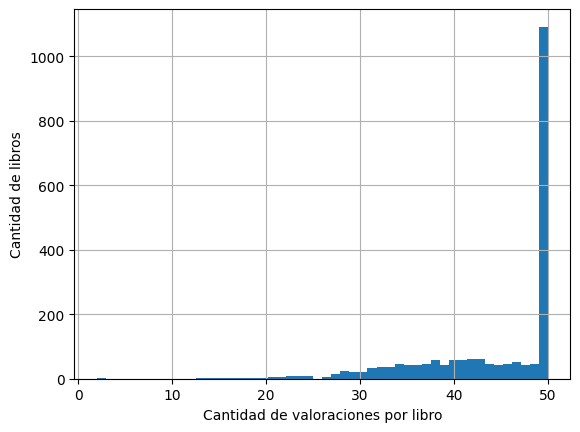

In [16]:
data = df_new.groupby('ISBN')['bookRating'].count()

data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por libro')
plt.ylabel('Cantidad de libros')
plt.show()

## Búsqueda del mejor modelo 

In [18]:
Reader?

In [17]:
reader = Reader(rating_scale=(1, 10)) # 0 = N/A
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

benchmark = []
# Iterate over all algorithms
for i, algorithm in enumerate([SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), #SVDpp
                 KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]):
    # Perform cross validation
    print(i)
    try:
        results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
            # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp._append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
        print(tmp)
    except:
        continue


0
test_rmse    3.529172
fit_time     1.172601
test_time    0.316777
Algorithm         SVD
dtype: object
1
test_rmse    3.463752
fit_time      0.51042
test_time    2.624531
Algorithm    SlopeOne
dtype: object
2
test_rmse    3.849971
fit_time     1.773308
test_time    0.292532
Algorithm         NMF
dtype: object
3
test_rmse           4.604284
fit_time            0.096561
test_time           0.236809
Algorithm    NormalPredictor
dtype: object
4
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
test_rmse       3.486263
fit_time         0.64332
test_time       4.683637
Algorithm    KNNBaseline
dtype: object
5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing

[Overview](https://www.kdnuggets.com/2017/08/recommendation-system-algorithms-overview.html) de los algoritmos

Algunos:

- NormalPredictor : $\hat{r}_{ui}$ se muestrea de una distribución gaussiana con media $\hat{\mu}$ y desvío $\hat{\sigma}^2$ obtenidos por máxima verosimilitud utilizando los datos de entrenamiento.

- [BaselineOnly](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration) : $\hat{r}_{ui} = \mu + b_u + b_i$

- [kNNBasic](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration) : $\hat{r}_{ui} = \frac{\sum_{v \in vecinos}sim(u,v) \cdot r_{vi}}{\sum_{v \in vecinos} sim(u,v)}$

- [Matrix factorization](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) : $\hat{r}_{ui} = \mu + b_u + b_i + q_i^T p_u$ (si $\mu$, $b_u$ y $b_i$ son 0 se llama Probabilistic Matrix Factorization)

In [19]:
benchmark

[test_rmse    3.529172
 fit_time     1.172601
 test_time    0.316777
 Algorithm         SVD
 dtype: object,
 test_rmse    3.463752
 fit_time      0.51042
 test_time    2.624531
 Algorithm    SlopeOne
 dtype: object,
 test_rmse    3.849971
 fit_time     1.773308
 test_time    0.292532
 Algorithm         NMF
 dtype: object,
 test_rmse           4.604284
 fit_time            0.096561
 test_time           0.236809
 Algorithm    NormalPredictor
 dtype: object,
 test_rmse       3.486263
 fit_time         0.64332
 test_time       4.683637
 Algorithm    KNNBaseline
 dtype: object,
 test_rmse    3.683293
 fit_time     0.453787
 test_time    3.627293
 Algorithm    KNNBasic
 dtype: object,
 test_rmse        3.481712
 fit_time         0.477725
 test_time        4.070351
 Algorithm    KNNWithMeans
 dtype: object,
 test_rmse         3.503097
 fit_time          0.609941
 test_time         4.196656
 Algorithm    KNNWithZScore
 dtype: object,
 test_rmse        3.388296
 fit_time          0.20364
 test_

In [20]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.388296,0.203640,0.256853
SlopeOne,3.463752,0.510420,2.624531
CoClustering,3.465800,1.901820,0.419999
KNNWithMeans,3.481712,0.477725,4.070351
KNNBaseline,3.486263,0.643320,4.683637
KNNWithZScore,3.503097,0.609941,4.196656
SVD,3.529172,1.172601,0.316777
KNNBasic,3.683293,0.453787,3.627293
NMF,3.849971,1.773308,0.292532


## Selección de modelo y selección de hiperparámetros

Nos quedamos con el algoritmo `BaselineOnly()`. Además vamos a utilizar el método [Alternating Least Squares](https://sophwats.github.io/2018-04-05-gentle-als.html) para encontrar los $b_u$ y $b_i$

In [21]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.37252792, 3.39486319, 3.38266551]),
 'fit_time': (0.12976980209350586, 0.1406090259552002, 0.14025235176086426),
 'test_time': (0.14576983451843262, 0.20674490928649902, 0.20055246353149414)}

In [22]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)

Estimating biases using als...


## Analizando los resultados

In [23]:
predictions

[Prediction(uid=238864, iid='0440237262', r_ui=0.0, est=1.410937591281275, details={'was_impossible': False}),
 Prediction(uid=178522, iid='0446606324', r_ui=9.0, est=4.607803619839892, details={'was_impossible': False}),
 Prediction(uid=122793, iid='0316899984', r_ui=0.0, est=2.71384996463017, details={'was_impossible': False}),
 Prediction(uid=145449, iid='043935806X', r_ui=7.0, est=4.5007947781845115, details={'was_impossible': False}),
 Prediction(uid=42458, iid='0786866845', r_ui=0.0, est=5.856741812655169, details={'was_impossible': False}),
 Prediction(uid=267538, iid='0446608653', r_ui=0.0, est=1.843359209315468, details={'was_impossible': False}),
 Prediction(uid=28634, iid='0425144429', r_ui=8.0, est=6.149643178290571, details={'was_impossible': False}),
 Prediction(uid=19522, iid='0553561618', r_ui=0.0, est=1.7714964542811407, details={'was_impossible': False}),
 Prediction(uid=123790, iid='042510687X', r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=123

In [24]:
accuracy.rmse(predictions)

RMSE: 3.3680


3.368000684947241

In [25]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


In [26]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [27]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,238864,0440237262,0.0,1.410938,{'was_impossible': False},34,32,1.410938
1,178522,0446606324,9.0,4.607804,{'was_impossible': False},43,70,4.392196
2,122793,0316899984,0.0,2.713850,{'was_impossible': False},79,94,2.713850
3,145449,043935806X,7.0,4.500795,{'was_impossible': False},58,156,2.499205
4,42458,0786866845,0.0,5.856742,{'was_impossible': False},24,23,5.856742


Podemos guardar las mejores y peores predicciones

In [28]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [29]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
15718,243876,0971880107,1.0,1.000000,{'was_impossible': False},2,628,0.000000
28125,41667,0971880107,1.0,1.000000,{'was_impossible': False},10,628,0.000000
15839,251422,0971880107,1.0,1.000000,{'was_impossible': False},117,628,0.000000
28757,132492,0971880107,1.0,1.000000,{'was_impossible': False},0,628,0.000000
12898,126693,0971880107,1.0,1.000000,{'was_impossible': False},65,628,0.000000
27095,258938,0971880107,1.0,1.000000,{'was_impossible': False},63,628,0.000000
27758,30972,0971880107,1.0,1.000000,{'was_impossible': False},104,628,0.000000
23143,82407,067976402X,2.0,1.999938,{'was_impossible': False},33,236,0.000062
17841,219683,0451184963,5.0,5.002145,{'was_impossible': False},47,91,0.002145
4136,70666,0345354613,5.0,5.002445,{'was_impossible': False},33,50,0.002445


In [30]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
23811,69697,0425173631,10.0,1.000000,{'was_impossible': False},144,39,9.000000
30913,51450,0515116068,10.0,1.000000,{'was_impossible': False},80,25,9.000000
23799,81977,0452260116,10.0,1.000000,{'was_impossible': False},56,55,9.000000
15050,107453,0671670689,10.0,1.000000,{'was_impossible': False},36,61,9.000000
10258,253106,0316781266,10.0,1.000000,{'was_impossible': False},30,75,9.000000
441,16916,0399150439,10.0,1.000000,{'was_impossible': False},74,24,9.000000
28080,196077,0449223604,10.0,1.000000,{'was_impossible': False},281,77,9.000000
29702,245864,0345409876,10.0,1.000000,{'was_impossible': False},35,28,9.000000
5062,31826,043935806X,0.0,9.519537,{'was_impossible': False},79,156,9.519537
2230,31826,0439139597,0.0,9.933711,{'was_impossible': False},79,76,9.933711


Qué está pasando con esos casos?

In [31]:
book = '0590353403'
df_new.loc[df_new['ISBN'] == book]['bookRating'].describe()

count    102.000000
mean       6.460784
std        4.251200
min        0.000000
25%        0.000000
50%        8.000000
75%       10.000000
max       10.000000
Name: bookRating, dtype: float64

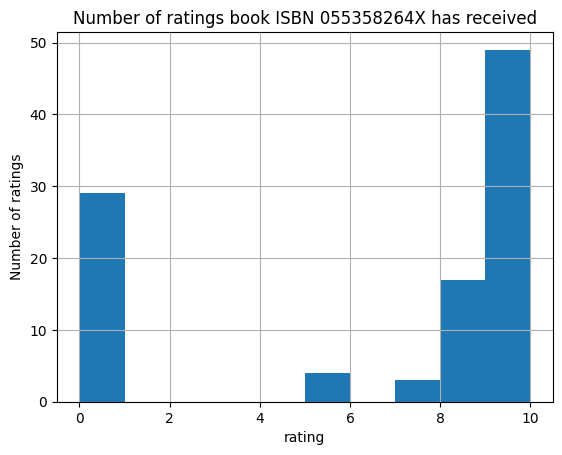

In [32]:
df_new.loc[df_new['ISBN'] == book]['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show()

Ejemplo extraído de [acá](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb)

## Referencias:

 * [Documentación de Surprise](https://surpriselib.com/)